In [1]:
!pip install tensorflow
!pip install matplotlib
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import tensorflow as tf

2022-07-13 09:38:43.192336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-13 09:38:43.192383: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# read dataset

# dataset origin https://archive.ics.uci.edu/ml/datasets/covertype
file_path = "/home/adrian/Pobrane/covtype.data"

defaults = [tf.int32] * 55 # number of columns
dataset = tf.data.experimental.CsvDataset(file_path, defaults)

# lets take a look
# print(list(dataset.take(1)))

2022-07-13 09:38:46.142489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-13 09:38:46.142510: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-13 09:38:46.142530: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (adrian-pc): /proc/driver/nvidia/version does not exist
2022-07-13 09:38:46.144283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# split to features and labels 

columns = [
    "Elevation", 
    "Aspect", 
    "Slope", 
    "Horizontal_Distance_To_Hydrology", 
    "Vertical_Distance_To_Hydrology", 
    "Horizontal_Distance_To_Roadways", 
    "Hillshade_9am",
    "Hillshade_Noon", 
    "Hillshade_3pm", 
    "Horizontal_Distance_To_Fire_Points", 
    "Soil_Type", 
    "Cover_Type"
    ]

def _parse_csv_data(*vals):
    
    soil_type = tf.convert_to_tensor(vals[14:54])
    
    feature_vals = (*vals[:10], soil_type, vals[54])
    features = dict(zip(columns, feature_vals))
    
    label = tf.argmax(vals[10:14], axis=0)
    
    return features, label

In [5]:
# check 

dataset = dataset.map(_parse_csv_data)
print(list(dataset.take(1)))

# dataset = dataset.batch(64)
#print(list(dataset.take(1)))

[({'Elevation': <tf.Tensor: shape=(), dtype=int32, numpy=2596>, 'Aspect': <tf.Tensor: shape=(), dtype=int32, numpy=51>, 'Slope': <tf.Tensor: shape=(), dtype=int32, numpy=3>, 'Horizontal_Distance_To_Hydrology': <tf.Tensor: shape=(), dtype=int32, numpy=258>, 'Vertical_Distance_To_Hydrology': <tf.Tensor: shape=(), dtype=int32, numpy=0>, 'Horizontal_Distance_To_Roadways': <tf.Tensor: shape=(), dtype=int32, numpy=510>, 'Hillshade_9am': <tf.Tensor: shape=(), dtype=int32, numpy=221>, 'Hillshade_Noon': <tf.Tensor: shape=(), dtype=int32, numpy=232>, 'Hillshade_3pm': <tf.Tensor: shape=(), dtype=int32, numpy=148>, 'Horizontal_Distance_To_Fire_Points': <tf.Tensor: shape=(), dtype=int32, numpy=6279>, 'Soil_Type': <tf.Tensor: shape=(40,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>, 'Cover_Type': <tf.Tensor: shape=(), dtype=int32, numpy=5>}, <tf.Tensor: shape=(), dtype=int64, 

In [6]:
# define features

numeric_columns = [
    "Elevation", 
    "Aspect", 
    "Slope", 
    "Horizontal_Distance_To_Hydrology", 
    "Vertical_Distance_To_Hydrology", 
    "Horizontal_Distance_To_Roadways", 
    "Hillshade_9am",
    "Hillshade_Noon", 
    "Hillshade_3pm", 
    "Horizontal_Distance_To_Fire_Points", 
]
numeric_features = [tf.feature_column.numeric_column(col) for col in numeric_columns]

cover_type = tf.feature_column.categorical_column_with_identity("Cover_Type", num_buckets=8)
cover_embedding = tf.feature_column.embedding_column(cover_type, dimension=10)

soil_type = tf.feature_column.numeric_column("Soil_Type", shape=(40,))


In [7]:
# define 1st layer for the model
features = numeric_features + [soil_type, cover_embedding]
feature_layer = tf.keras.layers.DenseFeatures(features)

In [8]:
# split to training and testing dataset
instances = 581012
test_dataset_size = int(0.15 * instances)
#print(test_dataset_size)

test_dataset = dataset.take(test_dataset_size).batch(64)
train_dataset = dataset.skip(test_dataset_size).batch(64)

In [9]:
# building model
model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(8),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

In [10]:
optimizer = tf.keras.optimizers.Adam()
    
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [11]:
EPOCHS = 1000
history = model.fit(train_dataset, steps_per_epoch=10, epochs=EPOCHS, verbose=0)

In [12]:
# inspect model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features (DenseFeatur  multiple                 80        
 es)                                                             
                                                                 
 dense (Dense)               multiple                  15616     
                                                                 
 dense_1 (Dense)             multiple                  4112      
                                                                 
 dense_2 (Dense)             multiple                  136       
                                                                 
 dense_3 (Dense)             multiple                  36        
                                                                 
Total params: 19,980
Trainable params: 19,980
Non-trainable params: 0
____________________________________________________

Index(['loss', 'accuracy', 'epoch'], dtype='object')


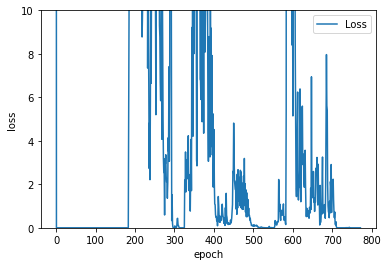

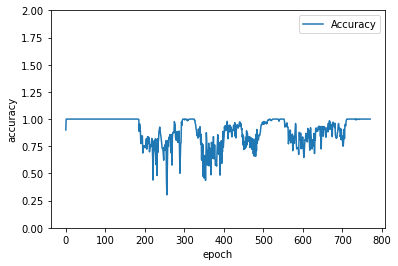

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch
    
    print(hist.columns)
    
    plt.figure()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    
    plt.plot(hist["epoch"], hist["loss"], label="Loss")
    
    
    plt.legend()
    plt.ylim([0, 10])
    
    plt.figure()
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    
    plt.plot(hist["epoch"], hist["accuracy"], label="Accuracy")
    
    plt.legend()
    plt.ylim([0, 2])
    
plot_history(history)

In [14]:
evaluation_result = model.evaluate(test_dataset, steps=550, verbose=0)

dict(zip(model.metrics_names, evaluation_result))

{'loss': 51.50634765625, 'accuracy': 0.4762499928474426}

In [15]:
def _extract_label(features, label):
    return label




test_predictions = model.predict(test_dataset)

print(f"test_predictions: {len(test_predictions)} ({test_predictions.shape}) {test_predictions[0]}")

test_labels = []

for _, label in test_dataset.as_numpy_iterator():
    test_labels.append(label)
    
test_labels = [x for xs in test_labels for x in xs]


    
    
#print(f"test_predictions: {len(test_predictions)} ({test_predictions.shape}), test_labels: {len(test_labels)} ({type(test_labels)})")

#plt.scatter(test_labels, test_predictions)
#plt.xlabel("true values")
#plt.ylabel("predictions")
#plt.axis("equal")
#plt.axis("square")
#plt.xlim([0, plt.xlim()[1]])
#plt.ylim([0, plt.ylim()[1]])

#_ = plt.plot([-100, 100], [-100, 100])

1362/1362 [==============================] - 5s 4ms/step
test_predictions: 87151 ((87151, 4)) [9.9999994e-01 1.9327642e-14 0.0000000e+00 0.0000000e+00]
